In [779]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import sklearn.neighbors as skln
import sklearn.metrics as sklm
import sklearn.cluster as sklc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import random
titanic = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#The ticket number of the passenger are all unique and don't have a concrete format. 
#Therefore, no analysis could be done on the ticket number and thus is dropped.
#The cabin number has lots of missing data and they can't be easily imputed (no average cabin number). 
#Thus, we drop the column 'cabin'.
#The names of the passengers don't really determine much and most are unique. 
#Thus, no analysis can be done on their name and thus is dropped.
titanic = titanic.drop('Ticket', axis=1)
titanic = titanic.drop('Cabin', axis=1)
titanic = titanic.drop('Name', axis=1)
titanic

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [780]:
#We find the mean for age, rounded it for simplicity, then imputed any missing values in Age with mean imputation. 
titanic_meanAge = round(titanic['Age'].mean(), 1)
titanic['Age'].fillna(titanic_meanAge, inplace = True)
titanic
#It didn't seem important in our cleaning to think about outliers in the age as none of the entries had ages that
# seemed unreasonable.


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,29.7,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [781]:
#THIS IS A CELL THAT WAS DECIDED TO BE KEPT IN, SO AS TO SHOW OUR PROCESS IN DECIDING THAT Fare IS ULTIMATELY 
#DROPPED FROM OUR ANALYSIS

titanic_dropFares = pd.DataFrame(titanic)
#This loop removes all entries that have a fare of 0 or less for calculating the mean, since 
#those entries are presumed to be missing values due to their lack of value. 
#The calculated mean will be used to impute those entries.
for x in titanic_dropFares.index:
  if titanic_dropFares.loc[x, "Fare"] <= 0:
    titanic_dropFares.drop(x, inplace = True)

titanic_averageFare = titanic_dropFares.groupby(by = 'Pclass').mean()
print(titanic_averageFare)

#Seperate dataframe into 3, spliting them across each ticket class x (['Pclass'] == x) because the ticket price is
#correlated to the ticket class the passenger purchased.
df1 = titanic[titanic['Pclass'] == 1]
df2 = titanic[titanic['Pclass'] == 2]
df3 = titanic[titanic['Pclass'] == 3]

#For each of the split dataframes, we found the 25th and 75th percentile of the variable Fare and then 
#found the difference to find the interquartile range.
#We calculate the Outliers with the formula:  Q3 + 1.5IQR AND Q1 - 1.5 IQR
q75, q25 = np.percentile (df1['Fare'], [75, 25])
iqr1 = q75 - q25
outlier_max1 = 1.5*iqr1 + q75
outlier_min1 = q25 - 1.5*iqr1
print('outlier max class 1: '+ str(outlier_max1))
print('outlier min class 1: '+ str(outlier_min1))

q75, q25 = np.percentile (df2['Fare'], [75, 25])
iqr2 = q75 - q25
outlier_max2 = 1.5*iqr2 + q75
outlier_min2 = q25 - 1.5*iqr2
print('outlier max class 2: '+ str(outlier_max2))
print('outlier min class 2: '+ str(outlier_min2))

q75, q25 = np.percentile (df3['Fare'], [75, 25])
iqr3 = q75 - q25
outlier_max3 = 1.5*iqr3 + q75
outlier_min3 = q25 - 1.5*iqr3
print('outlier max class 3: '+ str(outlier_max3))
print('outlier min class 3: '+ str(outlier_min3))

#All Fare = 0 entries are imputed with the mean of their respective ticket class
for x in df1.index:
    if df1.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][1]
for x in df2.index:
    if df2.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][2]
for x in df3.index:
    if df3.loc[x, "Fare"] == 0:
        titanic.loc[x,"Fare"]=titanic_averageFare['Fare'][3]
#Impute the missing embark location
randInt = int(round(2*random.random()))
if randInt == 0:
    print('Q')
    titanic['Embarked'].fillna('Q',inplace=True)
if randInt == 1:
    print('S')
    titanic['Embarked'].fillna('S',inplace=True)
if randInt == 2:
    print('C')
    titanic['Embarked'].fillna('C',inplace=True)
print(titanic['Embarked'][60:65])

        PassengerId  Survived        Age     SibSp     Parch       Fare
Pclass                                                                 
1        456.687204  0.644550  37.090142  0.426540  0.364929  86.148874
2        443.859551  0.488764  29.872640  0.415730  0.393258  21.358661
3        439.983573  0.242300  26.355483  0.620123  0.396304  13.787875
outlier max class 1: 187.364075
outlier min class 1: -62.940125
outlier max class 2: 45.5
outlier min class 2: -6.5
outlier max class 3: 27.125
outlier min class 3: -3.875
S
60    C
61    S
62    S
63    S
64    C
Name: Embarked, dtype: object


        PassengerId  Survived  Sex  Age  SibSp  Parch  Fare  Embarked
Pclass                                                               
1               216       216  216  216    216    216   216       216
2               184       184  184  184    184    184   184       184
3               491       491  491  491    491    491   491       491
     PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare  \
0              1         0       3    male  22.0      1      0   7.2500   
1              2         1       1  female  38.0      1      0  71.2833   
2              3         1       3  female  26.0      0      0   7.9250   
3              4         1       1  female  35.0      1      0  53.1000   
4              5         0       3    male  35.0      0      0   8.0500   
..           ...       ...     ...     ...   ...    ...    ...      ...   
886          887         0       2    male  27.0      0      0  13.0000   
887          888         1       1  female  19.0  

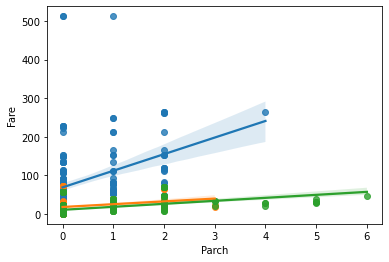

In [782]:
#THIS IS A CELL THAT WAS DECIDED TO BE KEPT IN, SO TO SHOW OUR PROCESS IN DECIDING THAT Fare IS ULTIMATELY 
#DROPPED FROM OUR ANALYSIS

#Count the entries by Pclass
titanic_count = titanic.groupby(by = 'Pclass').count()
print(titanic_count)
#This was an earlier attempt to see how many outliers there are by dropping them.
for x in df1.index:
    if df1.loc[x, "Fare"] >= outlier_max1:
        titanic = titanic.drop(x)
    if df1.loc[x, "Fare"] <= outlier_min1:
        titanic = titanic.drop(x)
#Removed 20 entries (There are 216 entries, so removing 20/216 = 9.259% of the 1st ticket class population)

for x in df2.index:
    if df2.loc[x, "Fare"] >= outlier_max2:
        titanic = titanic.drop(x)
    if df2.loc[x, "Fare"] <= outlier_min2:
        titanic = titanic.drop(x)
print(titanic)

#Removed 7 entries (There are 184 entries, so removing 7/184 = 3.8% of the 2nd ticket class population)

for x in df3.index:
    if df3.loc[x, "Fare"] >= outlier_max3:
        titanic = titanic.drop(x)
    if df3.loc[x, "Fare"] <= outlier_min3:
        titanic = titanic.drop(x)
print(titanic)

#Removed 52 entries (There are 491 entries, so removing 52/491 = 10.59% of the 3rd ticket class population)

#It was found that there is a large amount of outliers, especially the 1st and 3rd ticket classes. Looking back at the dataset, 
#it seemed like the fare was also tied to the Parch attribute, instead of just class. So, we graphed it and 
# it was true.
sea.regplot(x = df1['Parch'], y = df1['Fare'])
sea.regplot(x = df2['Parch'], y = df2['Fare'])
sea.regplot(x = df3['Parch'], y = df3['Fare'])

#We check how dropping the outliers affects the mean value of the attribute Parch and found that there was 
# a significant decrease in the mean of the attribute. 
print("Before removing outliers: ")
df1.insert(8, "Fare Per Dependant", df1["Fare"]/(df1[ "Parch"]+1))
df2.insert(8, "Fare Per Dependant", df2["Fare"]/(df2[ "Parch"]+1))
df3.insert(8, "Fare Per Dependant", df3["Fare"]/(df3[ "Parch"]+1))
titanic_survived = df1.groupby(by = 'Survived').mean()
print(titanic_survived)
titanic_survived = df2.groupby(by = 'Survived').mean()
print(titanic_survived)
titanic_survived = df3.groupby(by = 'Survived').mean()
print(titanic_survived)

for x in df1.index:
    if df1.loc[x, "Fare"] >= outlier_max1 or df1.loc[x, "Fare"] <= outlier_min1:
        df1 = df1.drop(x)
for x in df2.index:
    if df2.loc[x, "Fare"] >= outlier_max2 or df2.loc[x, "Fare"] <= outlier_min2:
        df2 = df2.drop(x)
for x in df3.index:
    if df3.loc[x, "Fare"] >= outlier_max3 or df3.loc[x, "Fare"] <= outlier_min3:
        df3 = df3.drop(x)
print("After removing outliers: ")
titanic_survived = df1.groupby(by = 'Survived').mean()
print(titanic_survived)
titanic_survived = df2.groupby(by = 'Survived').mean()
print(titanic_survived)
titanic_survived = df3.groupby(by = 'Survived').mean()
print(titanic_survived)

#WITH THIS, THE DATA IS DEEMED TO BE CLEANED!

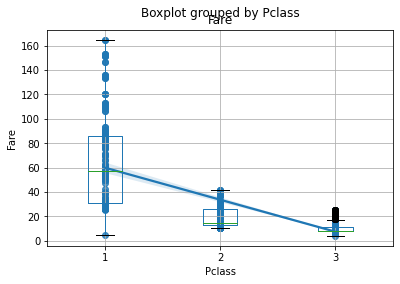

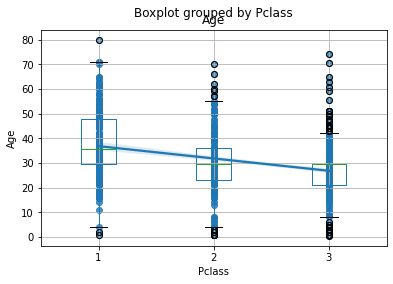

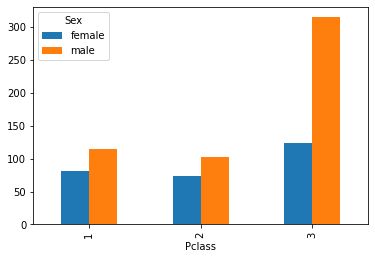

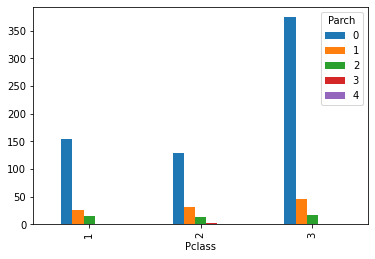

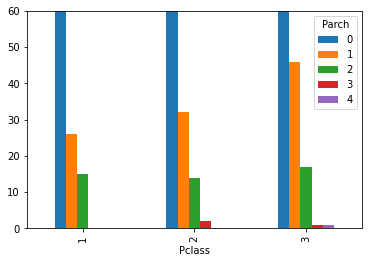

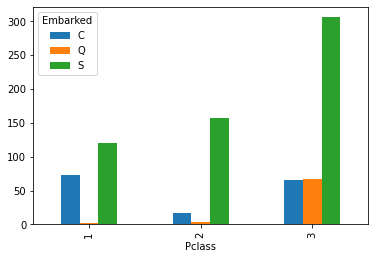

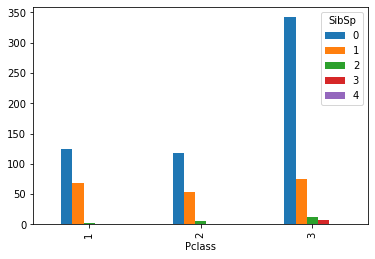

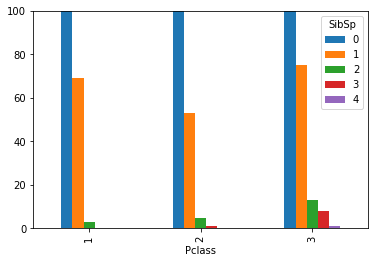

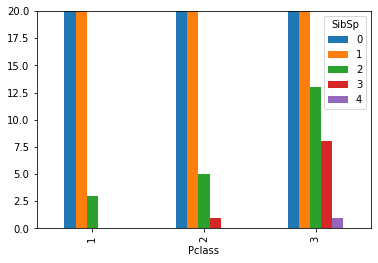

In [783]:
#The ticket class of a passenger seemed to be a good indicator of their socio-economic status as fare was
# correlated with their ticket class. The ticket class 1 was the most expensive and the ticket class 3
# 3 was the least expensive.
titanic.boxplot(column = 'Fare', by = 'Pclass')
sea.regplot(x = titanic['Pclass'], y = titanic['Fare'])


#To see how age is affected by Pclass, a box and whisker plot and a regression line from a scatter plot
# with the same attributes (Pclass vs. Age) is drawn. They both show a decrease in the age the lesser 
# socio-economic status. This could be a result of younger people having spent less time working and thus poorer.
titanic.boxplot(column = 'Age', by = 'Pclass')
sea.regplot(x = titanic['Pclass'], y = titanic['Age'])

#To see how gender is affected by Pclass, they were grouped together by Pclass and Sex and then plotted by count 
# as a bar graph. In the bar graph, the females were always less than the males, regardless of the Pclass. However,
# it seems like there is a significant number of males compared to females in the 3rd Pclass, almost twice the number
# of males compared to number females.

titanic_gender=titanic.groupby(['Pclass','Sex']).size()
titanic_gender=titanic_gender.unstack()
titanic_gender.plot(kind='bar')

#To see how the number of parents and children are affected by Pclass, a bar graph similar in implementation to 
# the Sex vs Pclass is done.
titanic_parch=titanic.groupby(['Pclass', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#The number of Parch being 0 is very prominent compared to every other number for the attribute Parch. The number 
# of Parch that were greater than 0 was so small compared that the same graph was made, but the y limit was set to 60
# ,so the other Parch attribute counts could be looked at. Overall, it seemed like a Power Law Distribution.
# Regardless of Pclass, most have Parch = 0, 1, or 2. Then, there are the very few that have Parch > 2
titanic_parch=titanic.groupby(['Pclass', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,60)

#Where the passenger embarked vs. their Pclass was also compared via bar graph. It seems to indicate that these places
# have different socioeconomic statuses. Queenstown seem to be the most prominent as barely any Pclass 1 or Pclass 2 
# was purchased in that port, almost all tickets were class 3, which makes Queenstown seem very poor. Cherbourg has 
# less people buying the class 3 ticket than class 1 tickets, showing that the population of Cherbourg seems to be 
# very wealthy. Southampton seems to have a Power Law Distribution, most people bought the cheapest ticket (Pclass 
# = 3)and the least people buying the most expensive ticket (Pclass = 1). This seems to indicate that Southampton 
# residents are average in wealth.
titanic_parch=titanic.groupby(['Pclass', 'Embarked']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#Finally, the class of the ticket is compared to the Sibsp of the passenger via another bar graph. 
# Like the Parent/Child graph, 0 siblings/Spouses is far greater than all the others
titanic_parch=titanic.groupby(['Pclass', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#In order to show the other groups more effectively, we set the limit of the graph to 100
# 1 siblings/Spouses is still far greater than the rest
titanic_parch=titanic.groupby(['Pclass', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,100)

#To show the other number of siblings and spouses effectively, we now set the limit to 20 
# A power law distribution would be most effective in representing this data
# While 0 siblings/Spouses is most common in all 3 classes, in 3rd class the number is far greater than in the other classes
# This suggests that a larger portion of those in 3rd class are single and have no siblings
titanic_parch=titanic.groupby(['Pclass', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,20)

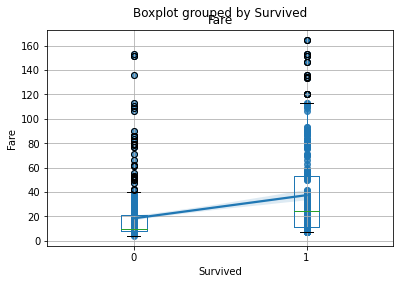

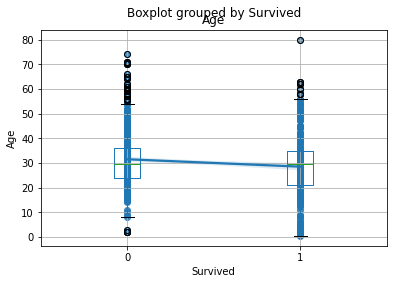

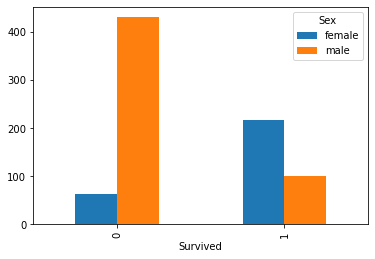

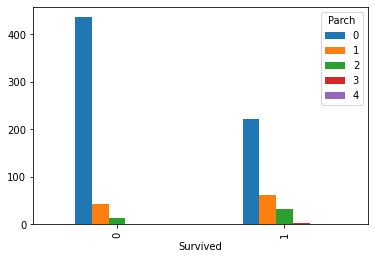

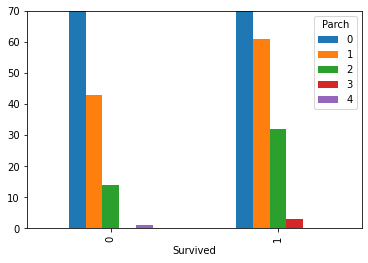

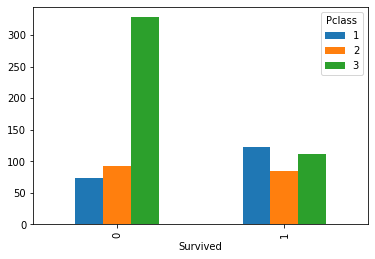

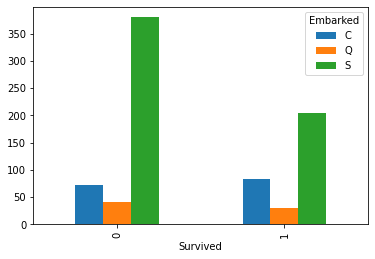

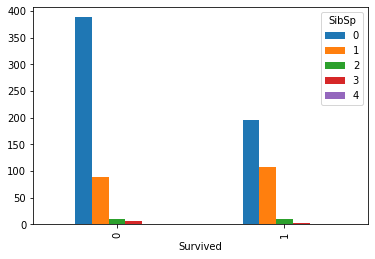

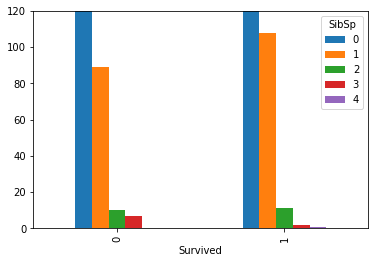

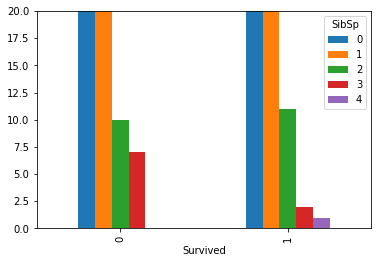

In [784]:
#The fare of a passenger seemed to be a good indicator of their survial, but that may be because fare was
# correlated with their ticket class and number of Parent/Childs.
titanic.boxplot(column = 'Fare', by = 'Survived')
sea.regplot(x = titanic['Survived']+1, y = titanic['Fare'])

#To see how age affected surival, a box and whisker plot from a scatter plot
# with the same attributes (Survived vs. Age) is drawn. They both show an average age of 30 for survived and not suvived 
# This suggests that the average age on the ship was 30 and the survival was distributed approximately normally. 
# However, there were less outliers for the box and whisker plot that survived
# This suggests that thre was a higher variance in the ages of those that survived
titanic.boxplot(column = 'Age', by = 'Survived')
sea.regplot(x = titanic['Survived']+1, y = titanic['Age'])

#To see how gender affected survival, they were grouped together by Survived and Sex and then plotted by count 
# as a bar graph. In the bar graph, the females were less than the males for not survived, but greater than males for survived.
# This suggests that females had a greater survival rate
titanic_gender=titanic.groupby(['Survived','Sex']).size()
titanic_gender=titanic_gender.unstack()
titanic_gender.plot(kind='bar')

#To see how the number of parents and children affected suvival, a bar graph similar in implementation to 
# the Sex vs Survived is done.
titanic_parch=titanic.groupby(['Survived', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#The number of Parch being 0 is very prominent compared to every other number for the attribute Parch. 
# The number of Parch that were greater than 0 was so small compared that the same graph was made,
# but the y limit was set to 70 so the other Parch attribute counts could be looked at. 
# Overall, it seemes like a Power Law Distribution.
# Regardless of Survival, most have Parch = 0, 1, or 2. Then, there are the very few that have Parch > 2
# Those that did not have a child had a much greater chance of not surviving.
# Those that only had one child had a slightly lower chance of surviving.
# Those with 2 children had approximately equal chance of surviving or not surviving
titanic_parch=titanic.groupby(['Survived', 'Parch']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,70)

#The socioeconomic class represented via ticket clas vs survival is compared using a bar graph
# For 3rd class tickets, the number that did not survive was much greater than those that did survive
# This suggests that being 3rd class means you are less likely to survive
titanic_pclass=titanic.groupby(['Survived', 'Pclass']).size()
titanic_pclass=titanic_pclass.unstack()
ax = titanic_pclass.plot(kind='bar')

#Where the passenger embarked vs. their survival was also compared via bar graph. 
# For both Southhampton and Queenstown, the portion that survived was less than those that did not survive
# However, for Cherbourg, the portion that survived was slightly greater than those that did not survive
# This suggests that embarking from Cherbourg indicated a greater chance for survival,
# but from our previous analysis of the socioeconomic status of Cherbourg, Cherbourg is likely also a wealthy location.
# Thus the reason that embarking from Cherbourg indicated a greater chance for survival is due to socioeconomic status.
titanic_parch=titanic.groupby(['Survived', 'Embarked']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#Finally, survival is compared to the Sibsp of the passenger via another bar graph.
# Like the Parent/Child graph, 0 siblings/Spouses is far greater than all the others
titanic_parch=titanic.groupby(['Survived', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')

#In order to show the other groups more effectively, we set the limit of the graph to 120
# 1 siblings/Spouses is still far greater than the rest
titanic_parch=titanic.groupby(['Survived', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,120)

#In order to show the other groups more effectively, we set the limit of the graph to 20
# 1 siblings/Spouses is still far greater than the rest
# A power law distribution would be best to represent this data
# While 0 siblings/Spouses is much larger in both survived and not survived, 
# there are much more with 0 siblings/Spouses that did not survive.
# This suggests that those with no family had a lower chance of survivng
titanic_parch=titanic.groupby(['Survived', 'SibSp']).size()
titanic_parch=titanic_parch.unstack()
ax = titanic_parch.plot(kind='bar')
ax = ax.set_ylim(0,20)

In [785]:
#For non-numerical features, assign a number to each category before comparing them
print('Correlation between Fare and Survived: '+str(titanic["Survived"].corr(titanic["Fare"])))
print('Correlation between Age and Survived: '+str(titanic["Survived"].corr(titanic["Age"])))
titanic_Sex = titanic['Sex'].map({'male':0,'female':1})
print('Correlation between Sex and Survived: '+str(titanic["Survived"].corr(titanic_Sex)))
print('Correlation between Parents/Children and Survived: '+str(titanic["Survived"].corr(titanic["Parch"])))
print('Correlation between Ticket class and Survived: '+str(titanic["Survived"].corr(titanic["Pclass"])))
titanic_Embark = titanic['Embarked'].map({'C':0,'Q':1,'S':2})
print('Correlation between Embarked location and Survived: '+str(titanic["Survived"].corr(titanic_Embark)))
print('Correlation between Siblings/Spouses and Survived: '+str(titanic["Survived"].corr(titanic["SibSp"])))
#Sex, Ticket class, and Fare seem to be the most important based on the correlation.
# For these features, the correlation is farthest from 0

Correlation between Fare and Survived: 0.31111854624240026
Correlation between Age and Survived: -0.11489319048111722
Correlation between Sex and Survived: 0.5698037272424478
Correlation between Parents/Children and Survived: 0.2251937294869241
Correlation between Ticket class and Survived: -0.32188912042147005
Correlation between Embarked location and Survived: -0.1509383470005134
Correlation between Siblings/Spouses and Survived: 0.14509042665484043


In [786]:
titanic_data=titanic.drop(columns = ['Sex', 'Embarked','Age','Parch','SibSp','PassengerId'], axis=1)
titanic_data.insert(3,'Sex',titanic_Sex)
titanic_training = titanic_data[0:int(round(titanic['Sex'].size*.75,0))]
titanic_testing = titanic_data[int((round(titanic['Sex'].size*.75,0))+1):]
titanic_data

,Survived,Pclass,Fare,Sex
0,0,3,7.2500,0
1,1,1,71.2833,1
2,1,3,7.9250,1
3,1,1,53.1000,1
4,0,3,8.0500,0
...,...,...,...,...
886,0,2,13.0000,0
887,1,1,30.0000,1
888,0,3,23.4500,1
889,1,1,30.0000,0


In [787]:
print('Shape of training data :',titanic_training.shape) 
print('Shape of testing data :',titanic_testing.shape) 

Shape of training data : (609, 4)
Shape of testing data : (202, 4)


In [788]:
train_x = titanic_training.drop(columns=['Survived'],axis=1)
train_y = titanic_training['Survived']
test_x = titanic_testing.drop(columns=['Survived'],axis=1)
test_y = titanic_testing['Survived']

In [789]:
model = skln.KNeighborsClassifier()
model.fit(train_x,train_y)

KNeighborsClassifier()

In [790]:
model.n_neighbors = 17
print('\nThe number of neighbors used to predict the target : ', model.n_neighbors)


The number of neighbors used to predict the target :  17


In [791]:
predict_train=model.predict(train_x)
print('\nTarget on train data: ', predict_train)


Target on train data:  [0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1
 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1
 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1
 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1
 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1
 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0
 

In [792]:
predict_test = model.predict(test_x)
print('Target on test data',predict_test)
print('Actual on test data',test_y.tolist())

Target on test data [0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1
 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1
 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0
 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0]
Actual on test data [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,

In [793]:
accuracy_test = sklm.accuracy_score(test_y,predict_test)
print('Accuracy on test dataset',accuracy_test)
precision_test = sklm.precision_recall_fscore_support(test_y, predict_test, average = 'binary')
print ('Precision_test : ', precision_test)
#The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
# instances of each class predicted. In our case, we decide to average out these scores and the result are:
#Precision = 0.65385
#Recall = 0.70833
#Fscore = 0.68
#The precision of the K- Nearest Neighbors is 65.385%. If (precision)^(-1), we will find out the precentage of 
#false positives compared to true positives. In this case, (.65385)^-1 = 1.529 = (true positive/true positive = 1) + 
# (false positive/true positive), which shows the ratio of false to true positive as .529 : 1 or 1: 1.889, which shows 
# that the precision score is poor as it means there is a false positive for less than every 2 true positives, a pretty 
# high ratio. 
# The recall of the K - Nearesr Neighbors is 70.833%. If we invert the formula like for precision, we find out that 
# (true positive + false negatives / true positive) = 1.41. The ratio comes out to be 1: 2.43 for false negatives to
# true positives, a fair recall score as less than 1/3 of all the predicted positives are wrong. 
# The F score is similar to the accuracy test, but it considered even better as it takes into account recall and 
# precision. The F score for this algorithm is 8 This means that the algorithm is good as it is better than a 50% 
# coin flip, but not very good as it is much less than 80% accurate.

Accuracy on test dataset 0.7623762376237624
Precision_test :  (0.6538461538461539, 0.7083333333333334, 0.68, None)


In [794]:
#logistic regression
train_x = titanic_training.drop(columns=['Survived'],axis=1)
train_y = titanic_training['Survived']
test_x = titanic_testing.drop(columns=['Survived'],axis=1)
test_y = titanic_testing['Survived']

In [804]:
model = LogisticRegression()
model.fit(train_x,train_y)
print('Coefficient of model :', model.coef_)
print('Intercept of model',model.intercept_)
predict_test = model.predict(test_x)

Coefficient of model : [[-8.30826472e-01  2.11272323e-03  2.63570295e+00]]
Intercept of model [0.38866679]


In [798]:
accuracy_test = sklm.accuracy_score(test_y,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)
precision_test = sklm.precision_recall_fscore_support(test_y, predict_test, average = 'binary')
print ('Precision_test : ', precision_test)
#The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
# instances of each class predicted. In our case, we decide to average out these scores and the result are:
#Precision = 0.79310
#Recall = 0.63888
#Fscore = 0.70769
#The precision of the Logistic Regression is 79.310%. If (precision)^(-1), we will find out the precentage of 
#false positives compared to true positives. In this case, (.79310)^-1 = 1.261 = (true positive/true positive = 1) + 
# (false positive/true positive), which shows the ratio of false to true positive as .261 : 1 or 1: 3.8, which shows 
# that the precision score is poor as it means there is a false positive for every 3.8 true positives, a low
# ratio. 
# The recall of the Logistic Regression is 63.888%. If we invert the formula like for precision, we find out that 
# (true positive + false negatives / true positive) = 1.56. The ratio comes out to be 1: 1.769 for false negatives to
# true positives, a very low score as more than 1/3 of all the predicted positives are wrong. 
# The F score is similar to the accuracy test, but it considered even better. The F score for this algorithm is 
# 70.769%. This means that the algorithm is good as it is better than a 50% coin flip, but not very good as it is
# much less than 80% accurate.

accuracy_score on test dataset :  0.8118811881188119
Precision_test :  (0.7931034482758621, 0.6388888888888888, 0.7076923076923076, None)


In [801]:
#The Machine Learning Algorithm used here is the Decision Tree Classifier Algorithm.
#For this algorithm, a feature is selected to be the root and then the branches, which represents a value or range 
# of values of that root feature, are formed from the root, seperating the data into each branch, where the data is
# has that root feature be that value or range of values. 
#Then, nodes are formed from the split data and for each node, the process is done again and again with another 
# feature not selected yet from the branch until all of the split data in a particular node has all the same class or
# no more attributes can be selected from a particular node.
#If the split has all the same process, the process is terminated for that node and it becomes a leaf with its class 
# being the class that the data has.
#If there are no more attributes to select from, all that split data will be used to see what class appears more 
# often. The node is terminated and becomes a leaf with the class that appears more often in the data. 
#Each record in the testing set will be checked against the tree with the record starting from the root of the tree
# and going to branches that fit the attribute it has and does this until it reaches a leaf with a class, that will
# be the class the decision tree classifier predicts it has. 

model = DecisionTreeClassifier()

train_x = titanic_training.drop(columns=['Survived'],axis=1)
train_y = titanic_training['Survived']
test_x = titanic_testing.drop(columns=['Survived'],axis=1)
test_y = titanic_testing['Survived']

model.fit(train_x,train_y)
predict_test = model.predict(test_x)

accuracy_test = sklm.accuracy_score(test_y,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)
precision_test = sklm.precision_recall_fscore_support(test_y, predict_test, average = 'binary')
print ('Precision_test : ', precision_test)
#The precision_recall_fscore_support method allows to show the precision, recall, f score, and number of 
# instances of each class predicted. In our case, we decide to average out these scores and the result are:
#Precision = 0.78125
#Recall = 0.69444
#Fscore = 0.73529
#The precision of the Decision Tree Classifier is 78.125%. If (precision)^(-1), we will find out the precentage of 
#false positives compared to true positives. In this case, (.78125)^-1 = 1.28 = (true positive/true positive = 1) + 
# (false positive/true positive), which shows the ratio of false to true positive as .28 : 1 or 1: 3.6, which shows 
# that the precision score is good as it means there is a false positive for every 3.6 true positives, a low
# ratio. 
# The recall of the Decision Tree Classifier is 69.444%. If we invert the formula like for precision, we find out that 
# (true positive + false negatives / true positive) = 1.44. This shows that for there is almost 1 false negative for 
# every 2 true positives, meaning 33% of all positive predictions were wrong. This seems very high and, and thus, is 
# a very poor recall score. 
# F score is considered a better test of accuracy and overall, the F score is 73.529%, a good score that is better 
# than 50% coin flip, but also, not very good as it is lower than 80%.

accuracy_score on test dataset :  0.8217821782178217
Precision_test :  (0.78125, 0.6944444444444444, 0.7352941176470588, None)
